In [1]:
require(ggplot2)
require(data.table)
require(Hmisc)
require(ggthemes)
require(gridExtra)
require(grid)
require(lattice)
require(scales)
require(RColorBrewer)
require(reshape)

Loading required package: ggplot2
Loading required package: data.table
Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units

Loading required package: ggthemes
Loading required package: gridExtra
Loading required package: grid
Loading required package: scales
Loading required package: RColorBrewer
Loading required package: reshape

Attaching package: ‘reshape’

The following object is masked from ‘package:data.table’:

    melt



In [2]:
# Used for p-rule/s-rule plots
# directory = "/mnt/sdb1/baseerat/numerical-evals/12-11-2017/logs-1M"
directory = "../12-11-2017/logs-1M"
blues = brewer.pal(n = 6, "Blues")[4:6]
bluesLong = brewer.pal(n = 6, "Blues")[2:6]
plotTheme <- theme_hc() + theme(legend.title=element_blank(), 
                                legend.position="none", 
                                text=element_text(size=16),
                                axis.title.x=element_text(size=13),
                                panel.spacing.y=unit(1.5, "lines"))

In [3]:
replaceFactors <- function(dt) {
    dt <- dt[placementNumHostsPerLeaf %in% c('uniform', '12')]
    dt[placementNumHostsPerLeaf == '12']$placementNumHostsPerLeaf <- "P=12"
    dt[placementNumHostsPerLeaf == 'uniform']$placementNumHostsPerLeaf <- "P=1"
    dt[groupSizeDist == "wve"]$groupSizeDist <- "WVE"
    dt[groupSizeDist == "uniform"]$groupSizeDist <- "Uniform"
    if("podsAlgorithm" %in% colnames(dt)) {
       dt <- dt[podsAlgorithm != "exact-match" & podsRedundancyPerBitmap <= 12 & podsNumBitmaps != 3]
    }
    if ("leafsAlgorithm" %in% colnames(dt)) {
       dt <- dt[leafsAlgorithm != "exact-match" & leafsRedundancyPerBitmap <= 12  & leafsNumBitmaps != 20]
    }
    return(dt)
}

rulesLabeller <- function(rules) {
    paste("F: ", rules, sep="")
}

format_si <- function(...) {
  # Format a vector of numeric values according
  # to the International System of Units.
  # http://en.wikipedia.org/wiki/SI_prefix
  #
  # Based on code by Ben Tupper
  # https://stat.ethz.ch/pipermail/r-help/2012-January/299804.html
  # Args:
  #   ...: Args passed to format()
  #
  # Returns:
  #   A function to format a vector of strings using
  #   SI prefix notation
  #
  
  function(x) {
    limits <- c(1e-24, 1e-21, 1e-18, 1e-15, 1e-12,
                1e-9,  1e-6,  1e-3,  1e0,   1e3,
                1e6,   1e9,   1e12,  1e15,  1e18,
                1e21,  1e24)
    prefix <- c("y",   "z",   "a",   "f",   "p",
                "n",   "µ",   "m",   " ",   "K",
                "M",   "G",   "T",   "P",   "E",
                "Z",   "Y")
  
    # Vector with array indices according to position in intervals
    i <- findInterval(abs(x), limits)
  
    # Set prefix to " " for very small values < 1e-24
    i <- ifelse(i==0, which(limits == 1e0), i)

    paste(format(round(x/limits[i], 1),
                 trim=TRUE, scientific=FALSE, ...),
          prefix[i], sep="")
  }
}

In [4]:
groupsCoveredWithBitmapsOnlyForLeafs <- replaceFactors(fread(paste(directory, 
                                                   "groups_covered_with_bitmaps_only_for_leafs.csv", sep="/"), sep=",", 
                                             header=TRUE))
ruleCountForLeafs <- replaceFactors(fread(paste(directory, "rule_count_for_leafs.csv", sep="/"), sep=",", header=TRUE))

In [5]:
groupsCoveredWithBitmapsOnlyForLeafs[leafsNumRules == 10000 & 
                                                 placementNumHostsPerLeaf == "P=12" &
                                                 leafsNumBitmaps == 30 &
                                                 groupSizeDist == "Uniform",mean(groupsCoveredWithoutDefaultBitmap),
                                    by=list(leafsRedundancyPerBitmap)]

leafsRedundancyPerBitmap,V1
0,814195.3
12,922015.3
6,876017.7


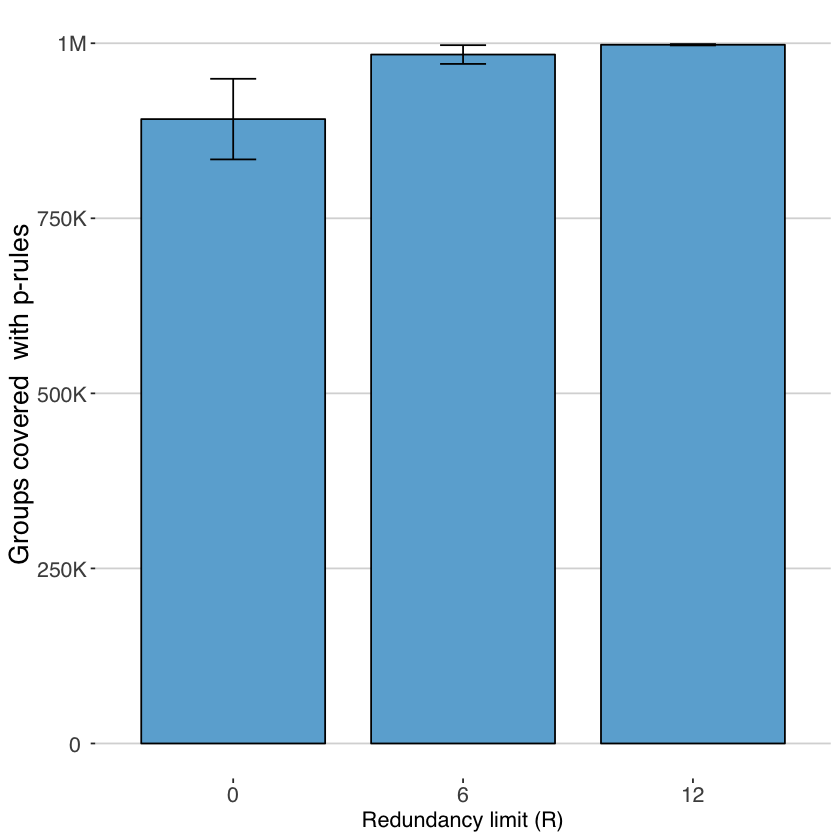

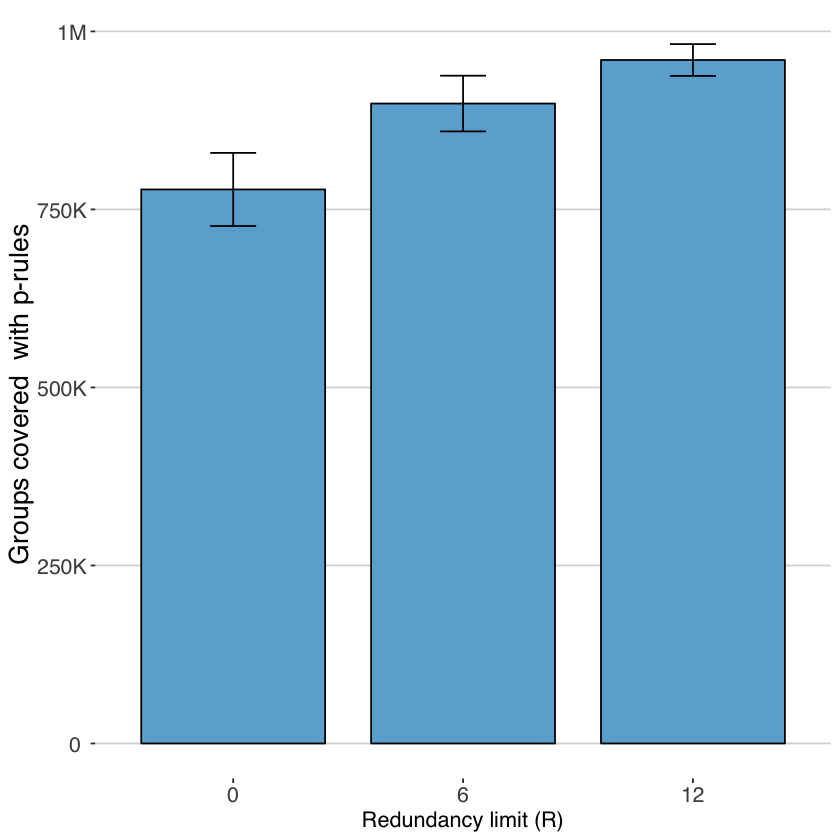

In [6]:
gcPlot <- ggplot(groupsCoveredWithBitmapsOnlyForLeafs[leafsNumRules == 10000 & 
                                                 placementNumHostsPerLeaf == "P=12" &
                                                 leafsNumBitmaps == 30 &
                                                 groupSizeDist == "WVE"], 
             aes(y=groupsCoveredWithoutDefaultBitmap, x=factor(leafsRedundancyPerBitmap), 
                fill="all")) +
   stat_summary(fun.data=mean_sdl, geom="bar",position=position_dodge(width=0.8), width=0.8, col="black") +
   stat_summary(fun.data=mean_sdl, geom="errorbar",position=position_dodge(width=0.8), width=0.2) +
   xlab("Redundancy limit (R)") +
   ylab("Groups covered  with p-rules") +
   scale_fill_manual(values=blues, name="Redundancy") +
   scale_y_continuous(labels=format_si()) +
   plotTheme + theme(legend.position="none")
ggsave(gcPlot, file="groups_covered__wve_p-rules=30_p=12_all.pdf",  height=3.5, width=8/3)
gcPlot

gcPlotP1 <- ggplot(groupsCoveredWithBitmapsOnlyForLeafs[leafsNumRules == 10000 & 
                                                 placementNumHostsPerLeaf == "P=1" &
                                                 leafsNumBitmaps == 30 &
                                                 groupSizeDist == "WVE"], 
             aes(y=groupsCoveredWithoutDefaultBitmap, x=factor(leafsRedundancyPerBitmap), 
                fill="all")) +
   stat_summary(fun.data=mean_sdl, geom="bar",position=position_dodge(width=0.8), width=0.8, col="black") +
   stat_summary(fun.data=mean_sdl, geom="errorbar",position=position_dodge(width=0.8), width=0.2) +
   xlab("Redundancy limit (R)") +
   ylab("Groups covered  with p-rules") +
   scale_fill_manual(values=blues, name="Redundancy") +
   scale_y_continuous(labels=format_si()) +
   plotTheme + theme(legend.position="none")
ggsave(gcPlotP1, file="groups_covered__wve_p-rules=30_p=1_all.pdf",  height=3.5, width=8/3)
gcPlotP1

In [7]:
ruleCountForLeafs[leafsNumRules == 64000 & 
                                 placementNumHostsPerLeaf == "P=12" &
                                 leafsNumBitmaps == 30 &
                                 groupSizeDist == "WVE", quantile(numRules,c(0.95)), by=list(leafsRedundancyPerBitmap)]

leafsRedundancyPerBitmap,V1
0,4059.3
12,16.0
6,466.2


In [8]:
bp.vals <- function(x) {
  r <- quantile(x, probs = c(0.05, 0.25, 0.5, 0.75, 0.95))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

Warning message:
“Removed 19 rows containing non-finite values (stat_summary).”Warning message:
“Removed 19 rows containing non-finite values (stat_summary).”

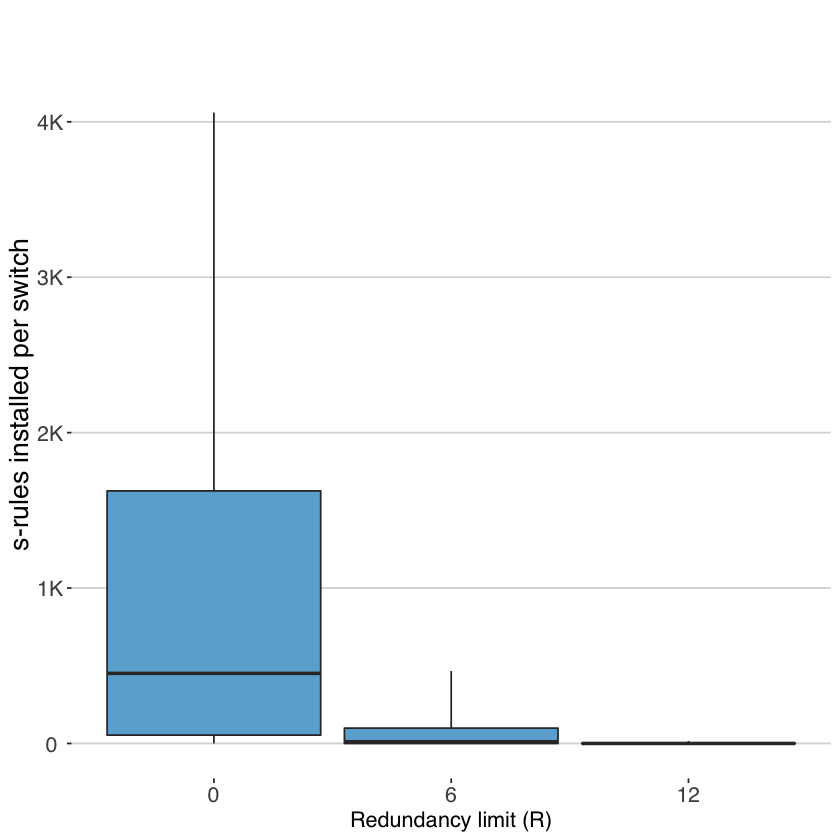

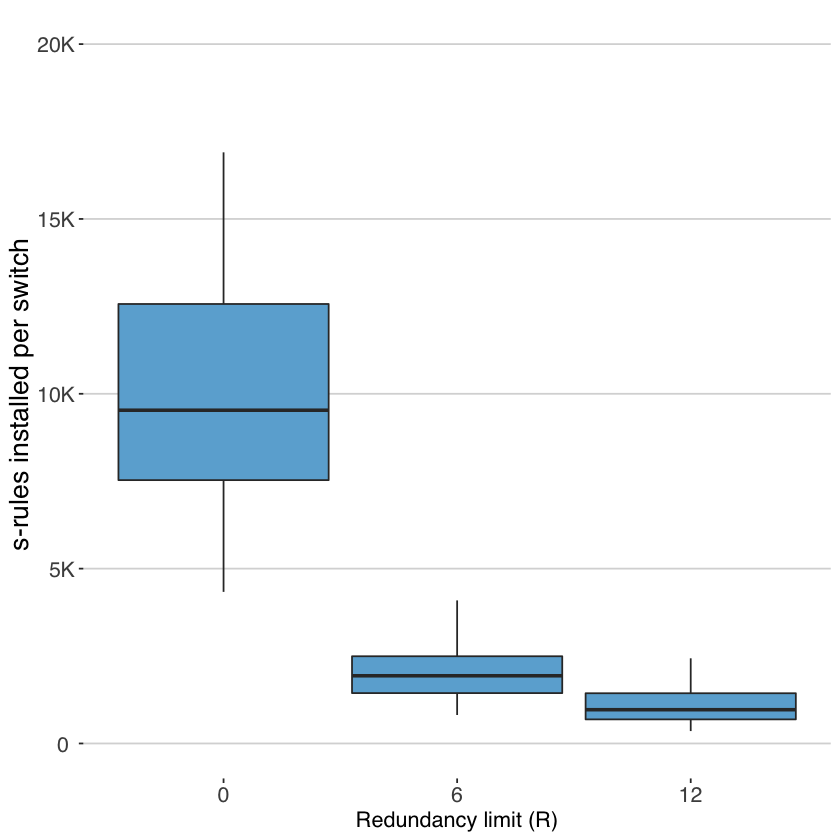

In [9]:
rulesPlot <- ggplot(ruleCountForLeafs[leafsNumRules == 64000 & 
                                 placementNumHostsPerLeaf == "P=12" &
                                 leafsNumBitmaps == 30 &
                                 groupSizeDist == "WVE"],
             aes(y=numRules, x=factor(leafsRedundancyPerBitmap), fill="blue")) +
#     stat_boxplot(fun.data=bp.vals, geom ='errorbar', width=0.5) +
    stat_summary(fun.data=bp.vals, geom="boxplot") +
#     geom_boxplot(outlier.shape=NA) +
    xlab("Redundancy limit (R)") +
    ylab("s-rules installed per switch") +
    scale_fill_manual(values=blues, name="Redundancy") +
    coord_cartesian(ylim=c(0, 4500)) +
    scale_y_continuous(labels=format_si()) +
    plotTheme  + theme(legend.position="none")
ggsave(rulesPlot, file="rule_count__wve_p-rules=30_p=12_all.pdf", height=3.5, width=8/3)
rulesPlot

rulesPlotP1 <- ggplot(ruleCountForLeafs[leafsNumRules == 64000 & 
                                 placementNumHostsPerLeaf == "P=1" &
                                 leafsNumBitmaps == 30 &
                                 groupSizeDist == "WVE"],
             aes(y=numRules, x=factor(leafsRedundancyPerBitmap), fill="blue")) +
#     stat_boxplot(geom ='errorbar', width=0.5) +
    stat_summary(fun.data=bp.vals, geom="boxplot") +
#     geom_boxplot(outlier.shape=NA) +
    xlab("Redundancy limit (R)") +
    ylab("s-rules installed per switch") +
    scale_fill_manual(values=blues, name="Redundancy") +
    scale_y_continuous(limit=c(0, 20000), labels=format_si()) +
    plotTheme  + theme(legend.position="none")
ggsave(rulesPlotP1, file="rule_count__wve_p-rules=30_p=1_all.pdf", height=3.5, width=8/3)
rulesPlotP1

In [10]:
# Used for traffic plots

# directory = "/mnt/sdc1/baseerat/numerical-evals/1-26-2018/logs-1M"
directory = "./logs-1M"
blues = brewer.pal(n = 6, "Blues")[4:6]
bluesLong = brewer.pal(n = 6, "Blues")[2:6]


In [11]:
trafficPerGroupPerTenant <- replaceFactors(fread(paste(directory, "traffic_per_group_per_tenant.csv", sep="/"), sep=",", 
                                  header=TRUE))
trafficPerGroupPerTenant$unicastTraffic <- as.numeric(trafficPerGroupPerTenant$unicastTraffic)
trafficPerGroupPerTenant$multicastTraffic <- as.numeric(trafficPerGroupPerTenant$multicastTraffic)
trafficPerGroupPerTenant$baseeratTraffic <- as.numeric(trafficPerGroupPerTenant$baseeratTraffic)
trafficPerGroupPerTenant$overlayTraffic <- as.numeric(trafficPerGroupPerTenant$overlayTraffic)
trafficPerGroupPerTenant$overlayTrafficCorrected <- as.numeric(trafficPerGroupPerTenant$overlayTrafficCorrected)

trafficPerGroupPerTenant$unicastTraffic1500B <- as.numeric(trafficPerGroupPerTenant$unicastTraffic1500B)
trafficPerGroupPerTenant$multicastTraffic1500B <- as.numeric(trafficPerGroupPerTenant$multicastTraffic1500B)
trafficPerGroupPerTenant$baseeratTraffic1500B <- as.numeric(trafficPerGroupPerTenant$baseeratTraffic1500B)
trafficPerGroupPerTenant$overlayTraffic1500B <- as.numeric(trafficPerGroupPerTenant$overlayTraffic1500B)
trafficPerGroupPerTenant$overlayTrafficCorrected1500B <- as.numeric(trafficPerGroupPerTenant$overlayTrafficCorrected1500B)


In [12]:
trafficMelted <- melt(trafficPerGroupPerTenant, id=c("groupSizeDist", "placementDist", "placementNumHostsPerLeaf", "seed",
                                    "podsAlgorithm", "podsNumBitmaps", "podsNumNodesPerBitmap",
                                    "podsRedundancyPerBitmap", "podsNumRules", "leafsAlgorithm",
                                    "leafsNumBitmaps", "leafsNumNodesPerBitmap", "leafsRedundancyPerBitmap",
                                    "leafsNumRules", "multicastTraffic", "multicastTraffic1500B"))

trafficMelted64 <- melt(trafficPerGroupPerTenant, id=c("groupSizeDist", "placementDist", "placementNumHostsPerLeaf", "seed",
                                    "podsAlgorithm", "podsNumBitmaps", "podsNumNodesPerBitmap",
                                    "podsRedundancyPerBitmap", "podsNumRules", "leafsAlgorithm",
                                    "leafsNumBitmaps", "leafsNumNodesPerBitmap", "leafsRedundancyPerBitmap",
                                    "leafsNumRules", "multicastTraffic", "multicastTraffic64B"))

In [13]:
trafficMelted <- trafficMelted[!(variable == "unicastTraffic" & leafsRedundancyPerBitmap > 0)]
trafficMelted <- trafficMelted[!(variable == "overlayTraffic")]
trafficMelted <- trafficMelted[!(variable == "overlayTrafficCorrected" & leafsRedundancyPerBitmap > 0)]
trafficMelted[variable == "baseeratTraffic"]$variable <- "Baseerat"
trafficMelted$redundancyAndAlgo <- interaction(trafficMelted$variable, 
                                               trafficMelted$leafsRedundancyPerBitmap, sep=":R=")
trafficMelted[redundancyAndAlgo == "unicastTraffic:R=0"]$redundancyAndAlgo <- "Unicast"

trafficMelted64 <- trafficMelted64[!(variable == "unicastTraffic" & leafsRedundancyPerBitmap > 0)]
trafficMelted64 <- trafficMelted64[!(variable == "overlayTraffic")]
trafficMelted64 <- trafficMelted64[!(variable == "overlayTrafficCorrected" & leafsRedundancyPerBitmap > 0)]
trafficMelted64[variable == "baseeratTraffic"]$variable <- "Baseerat"
trafficMelted64$redundancyAndAlgo <- interaction(trafficMelted64$variable, 
                                               trafficMelted64$leafsRedundancyPerBitmap, sep=":R=")
trafficMelted64[redundancyAndAlgo == "unicastTraffic:R=0"]$redundancyAndAlgo <- "Unicast"

In [14]:
blah <- trafficMelted[(redundancyAndAlgo == "overlayTrafficCorrected1500B:R=0" | 
                       redundancyAndAlgo ==  "baseeratTraffic1500B:R=0" |
                       redundancyAndAlgo == "baseeratTraffic1500B:R=6" | 
                       redundancyAndAlgo == "baseeratTraffic1500B:R=12" |
                       redundancyAndAlgo == "unicastTraffic1500B:R=0")]
blah[redundancyAndAlgo == "baseeratTraffic1500B:R=0"]$redundancyAndAlgo <- "Baseerat:R=0"
blah[redundancyAndAlgo == "baseeratTraffic1500B:R=6"]$redundancyAndAlgo <- "Baseerat:R=6"
blah[redundancyAndAlgo == "baseeratTraffic1500B:R=12"]$redundancyAndAlgo <- "Baseerat:R=12"
blah[redundancyAndAlgo == "overlayTrafficCorrected1500B:R=0"]$redundancyAndAlgo <- "Overlay Multicast"
blah[redundancyAndAlgo == "unicastTraffic1500B:R=0"]$redundancyAndAlgo <- "Unicast"

blah64 <- trafficMelted64[(redundancyAndAlgo == "overlayTrafficCorrected64B:R=0" | 
                       redundancyAndAlgo ==  "baseeratTraffic64B:R=0" |
                       redundancyAndAlgo == "baseeratTraffic64B:R=6" | 
                       redundancyAndAlgo == "baseeratTraffic64B:R=12" |
                       redundancyAndAlgo == "unicastTraffic64B:R=0")]
blah64[redundancyAndAlgo == "baseeratTraffic64B:R=0"]$redundancyAndAlgo <- "Baseerat:R=0"
blah64[redundancyAndAlgo == "baseeratTraffic64B:R=6"]$redundancyAndAlgo <- "Baseerat:R=6"
blah64[redundancyAndAlgo == "baseeratTraffic64B:R=12"]$redundancyAndAlgo <- "Baseerat:R=12"
blah64[redundancyAndAlgo == "overlayTrafficCorrected64B:R=0"]$redundancyAndAlgo <- "Overlay Multicast"
blah64[redundancyAndAlgo == "unicastTraffic64B:R=0"]$redundancyAndAlgo <- "Unicast"

In [15]:
moreColors <- c('#6BAED6', '#3182BD', '#08519C')
unicastAndMulticast <- blah[(redundancyAndAlgo=="Unicast" | redundancyAndAlgo == "Overlay Multicast") &
                            leafsNumRules == 64000 & 
                                 placementNumHostsPerLeaf == "P=12" &
                                 leafsNumBitmaps == 30 &
                                 groupSizeDist == "WVE",
                        mean(value/multicastTraffic1500B), by=list(redundancyAndAlgo, 
                                                                   placementNumHostsPerLeaf,
                                                                  groupSizeDist, leafsNumRules)]

unicastAndMulticastP1 <- blah[(redundancyAndAlgo=="Unicast" | redundancyAndAlgo == "Overlay Multicast") &
                            leafsNumRules == 64000 & 
                                 placementNumHostsPerLeaf == "P=1" &
                                 leafsNumBitmaps == 30 &
                                 groupSizeDist == "WVE",
                        mean(value/multicastTraffic1500B), by=list(redundancyAndAlgo, 
                                                                   placementNumHostsPerLeaf,
                                                                  groupSizeDist, leafsNumRules)]

In [16]:
unicastAndMulticastP1

redundancyAndAlgo,placementNumHostsPerLeaf,groupSizeDist,leafsNumRules,V1
Unicast,P=1,WVE,64000,4.069631
Overlay Multicast,P=1,WVE,64000,1.924691


In [17]:
blah[redundancyAndAlgo != "Unicast" & redundancyAndAlgo != "Overlay Multicast" &
                  leafsNumRules == 10000 & 
                                 placementNumHostsPerLeaf == "P=12" &
                                 leafsNumBitmaps == 30 &
                                 groupSizeDist == "Uniform",mean(value/multicastTraffic1500B),by=list(leafsRedundancyPerBitmap)]

leafsRedundancyPerBitmap,V1
0,1.004885
6,1.012126
12,1.027830


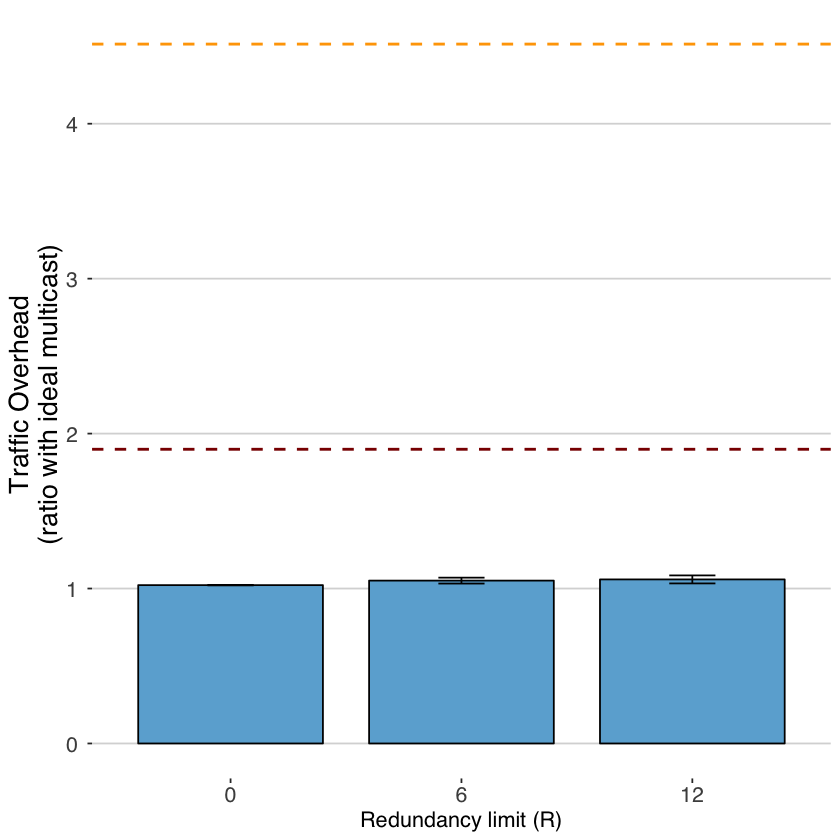

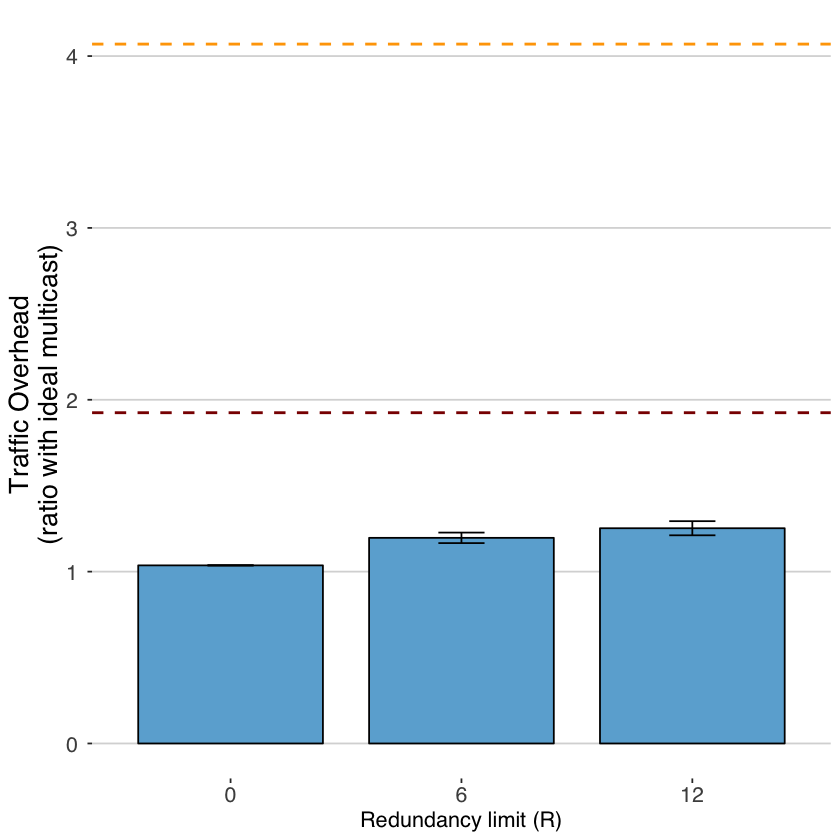

In [18]:
overheadPlot <- ggplot(blah[redundancyAndAlgo != "Unicast" & redundancyAndAlgo != "Overlay Multicast" &
                  leafsNumRules == 64000 & 
                                 placementNumHostsPerLeaf == "P=12" &
                                 leafsNumBitmaps == 30 &
                                 groupSizeDist == "WVE"], 
       aes(y=value/multicastTraffic1500B, x=factor(leafsRedundancyPerBitmap), 
           fill='blue')) +
    stat_summary(fun.data = mean_sdl, geom = "bar", position=position_dodge(0.8), width=0.8, col="black") +
    stat_summary(fun.data = mean_sdl, geom = "errorbar", position=position_dodge(0.8), width=0.2) +
    geom_hline(data=unicastAndMulticast[redundancyAndAlgo == "Unicast" ], 
               aes(yintercept=V1), linetype="dashed", col='orange', size=0.8) +
    geom_hline(data=unicastAndMulticast[redundancyAndAlgo == "Overlay Multicast" ], 
               aes(yintercept=V1), linetype="dashed", col='darkred', size=0.8) +
    xlab("Redundancy limit (R)") +
    ylab("Traffic Overhead\n(ratio with ideal multicast)") +
    scale_fill_manual(values=moreColors) +
   scale_y_continuous(labels=format_si()) +
   plotTheme + theme(legend.position="none")
ggsave(overheadPlot, file="traffic_overhead__wve_p-rules=30_p=12_all.pdf", height=3.5, width=8/3)
overheadPlot

overheadPlotp1 <- ggplot(blah[redundancyAndAlgo != "Unicast" & redundancyAndAlgo != "Overlay Multicast" &
                  leafsNumRules == 64000 & 
                                 placementNumHostsPerLeaf == "P=1" &
                                 leafsNumBitmaps == 30 &
                                 groupSizeDist == "WVE"], 
       aes(y=value/multicastTraffic1500B, x=factor(leafsRedundancyPerBitmap), 
           fill='blue')) +
    stat_summary(fun.data = mean_sdl, geom = "bar", position=position_dodge(0.8), width=0.8, col="black") +
    stat_summary(fun.data = mean_sdl, geom = "errorbar", position=position_dodge(0.8), width=0.2) +
    geom_hline(data=unicastAndMulticastP1[redundancyAndAlgo == "Unicast" ], 
               aes(yintercept=V1), linetype="dashed", col='orange', size=0.8) +
    geom_hline(data=unicastAndMulticastP1[redundancyAndAlgo == "Overlay Multicast" ], 
               aes(yintercept=V1), linetype="dashed", col='darkred', size=0.8) +
    xlab("Redundancy limit (R)") +
    ylab("Traffic Overhead\n(ratio with ideal multicast)") +
    scale_fill_manual(values=moreColors) +
   scale_y_continuous(labels=format_si()) +
   plotTheme + theme(legend.position="none")
ggsave(overheadPlotp1, file="traffic_overhead__wve_p-rules=30_p=1_all.pdf", height=3.5, width=8/3)
overheadPlotp1

Warning message:
“Removed 19 rows containing non-finite values (stat_summary).”

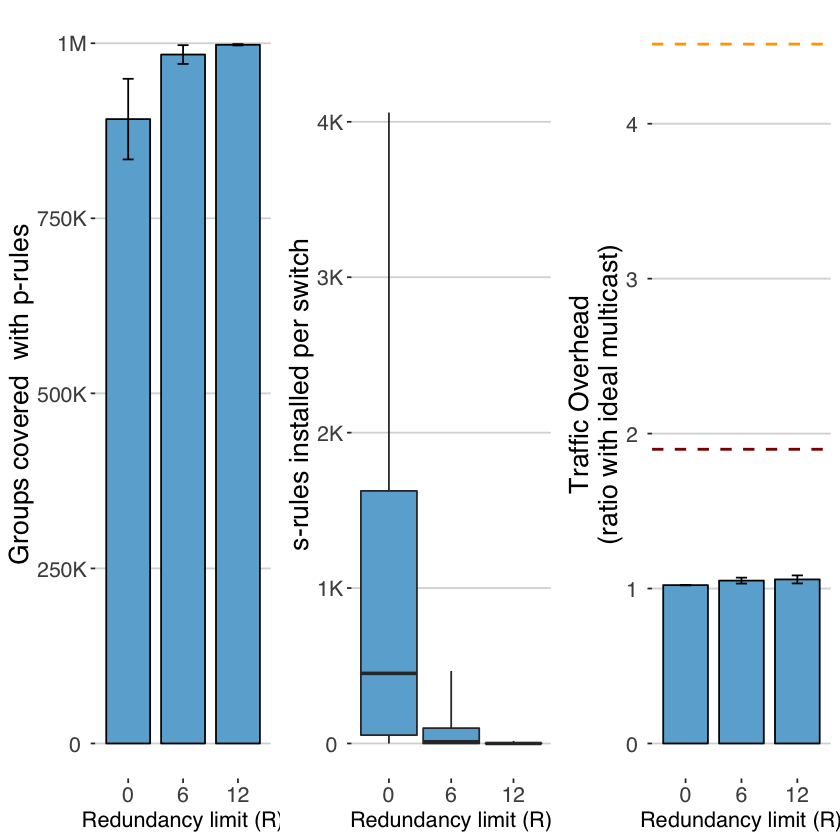

In [ ]:
combined <- grid.arrange(gcPlot, rulesPlot, overheadPlot, ncol=3)
ggsave(combined, height=3.5, width=8, file="wve_30prules_p=12_all.pdf")

combined <- grid.arrange(gcPlotP1, rulesPlotP1, overheadPlotp1, ncol=3)
ggsave(combined, height=3.5, width=8, file="wve_30prules_p=1_all.pdf")